In [51]:
# Libraries
from datetime import date
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
import pickle
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from dotenv import load_dotenv
from supabase import create_client
import os

In [52]:
# Read data
load_dotenv()

SUPABASE_URL = os.getenv("NEXT_PUBLIC_SUPABASE_URL")
SUPABASE_SERVICE_KEY = os.getenv("NEXT_PUBLIC_SUPABASE_SERVICE_KEY")

supabase = create_client(SUPABASE_URL, SUPABASE_SERVICE_KEY)

MAKE = "Fiat"
min_observations = 10

response = (
    supabase.table("bat_completed_auctions")
    .select("year, model, mileage, normalized_color, transmission, sold_price, bid_amount, end_date, status")
    .eq("make", MAKE)
    .not_.is_("mileage", None)
    .not_.is_("transmission", None)
    .execute()
)
df = pd.DataFrame(response.data)

In [53]:
# Count by model
counts = df[['model','status']].groupby('model').count().sort_values(by='status',ascending=False)
print(counts)

                             status
model                              
124 Spider                       97
500L                             71
124 Spider 2000                  50
X1/9                             49
Spider 2000                      35
...                             ...
500 Francis Lombardi My Car       1
500 Giardiniera Taxi              1
500 Jolly Project                 1
500 Jolly conversion              1
X1/9 Versione Speciale            1

[287 rows x 1 columns]


In [54]:
# Price by model
display_p=df[['model','year','sold_price']]

fig=px.box(display_p,x="model",y="sold_price")
fig.update_layout(title_text='Price vs Model',xaxis_title="Model",yaxis_title="Average Price")

In [55]:
# Filter to models with more than min_observations
counts=df['model'].value_counts()
frequent_models = counts[counts >= min_observations].index

# Filter the data to frequent models
df = df[df['model'].isin(frequent_models)]
popular_labels=frequent_models

colors=['lightslategray',]*len(popular_labels)
colors[0]='crimson'

fig=go.Figure(data=[go.Bar(x=counts[:25],y=popular_labels,marker_color=colors,orientation='h')])
fig.update_layout(title_text='Most represented Models in the Dataset',xaxis_title="Count",yaxis_title="Model")

In [56]:
#distribution of number of cars over the years
dic = {1970+i : sum(df['year']==1970+i) for i in range(55)}
x_dic = [1970 + i for i in range(55)]
y_dic = [dic[1970 + i] for i in range(55)]

# Plot
fig = go.Figure([go.Bar(x=x_dic, y=y_dic)])

fig.update_layout(title="Car year distribution",
                  xaxis_title="Year",
                  yaxis_title="Count Cars sold")


fig.show()

In [57]:
# Distribution of transmission
data_pie = df['transmission'].value_counts()

fig = go.Figure(data=[go.Pie(labels=data_pie.index, values=data_pie.tolist(), textinfo='label+percent',insidetextorientation='radial')])

fig.update_traces(hole=.3, hoverinfo="label+percent+name")

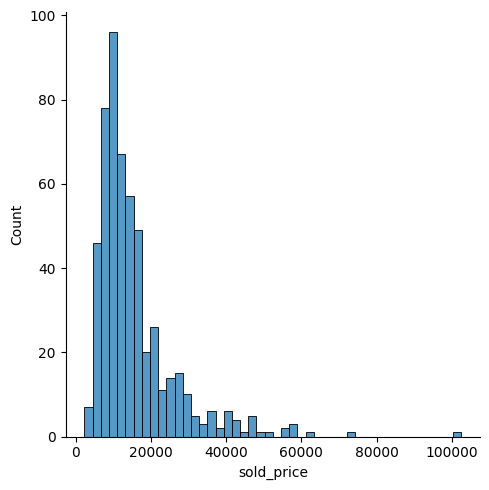

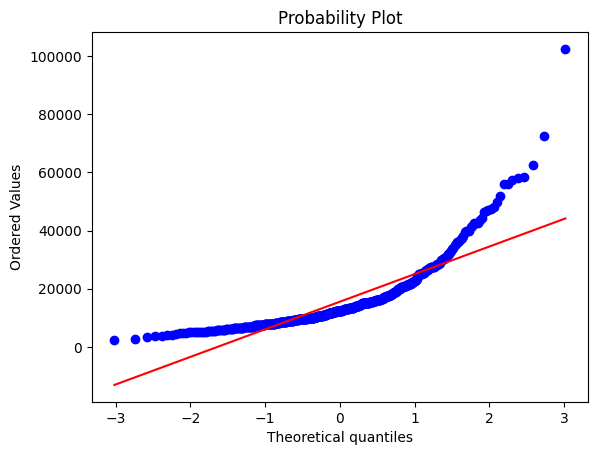

In [58]:
# Replace sold_price with bid_amount and remove outliers
df['sold_price'] = df['sold_price'].fillna(df['bid_amount'])
df = df.dropna()

# Remove outliers
price_threshold = 1000000
df.drop(df[df['sold_price'] >= price_threshold].index,inplace=True)

# Plot distribution of sold_price
sns.displot(df['sold_price'])
fig = plt.figure()
res = stats.probplot(df['sold_price'], plot=plt)


array([[<Axes: title={'center': 'year'}>,
        <Axes: title={'center': 'mileage'}>],
       [<Axes: title={'center': 'sold_price'}>,
        <Axes: title={'center': 'bid_amount'}>]], dtype=object)

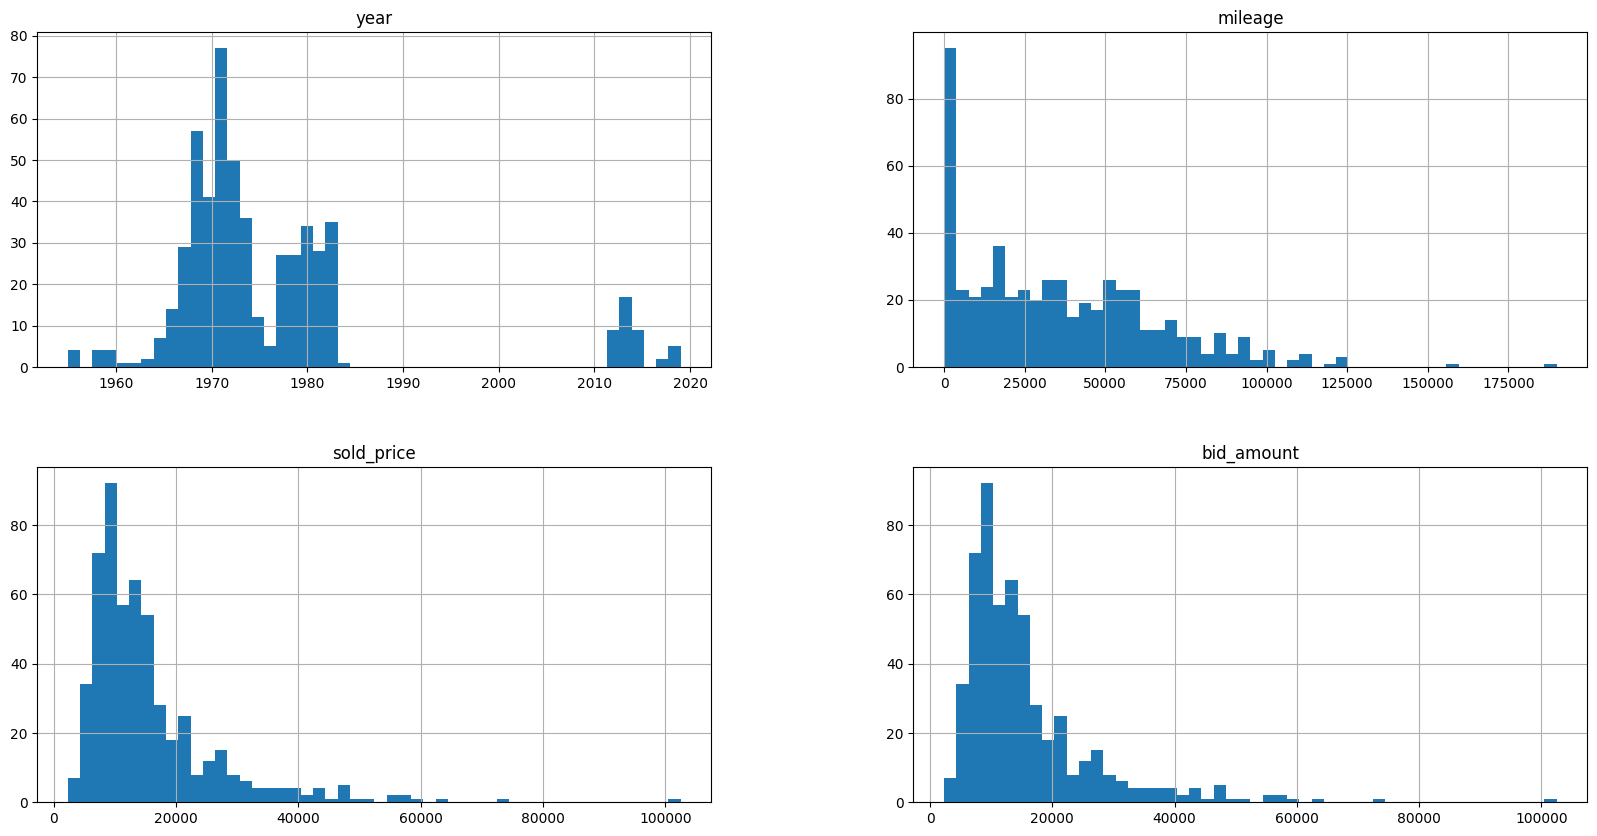

In [59]:
# Data distribution
df.hist(figsize=(20,10),bins = 50)

In [60]:
# Weight by recency
df['days_since_end'] = (pd.to_datetime(date.today()) - pd.to_datetime(df["end_date"])).dt.days
K = 1
T = 360
df['W'] = K*np.exp(-df['days_since_end']/T)


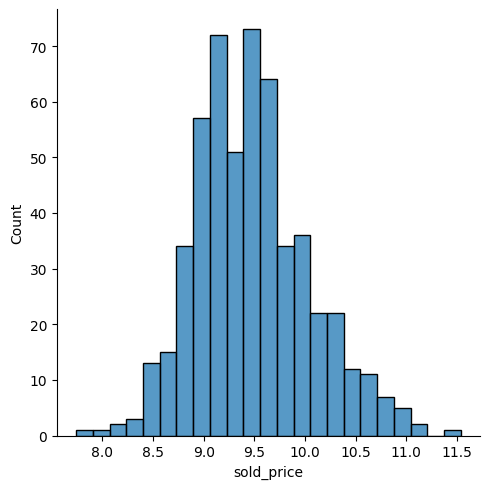

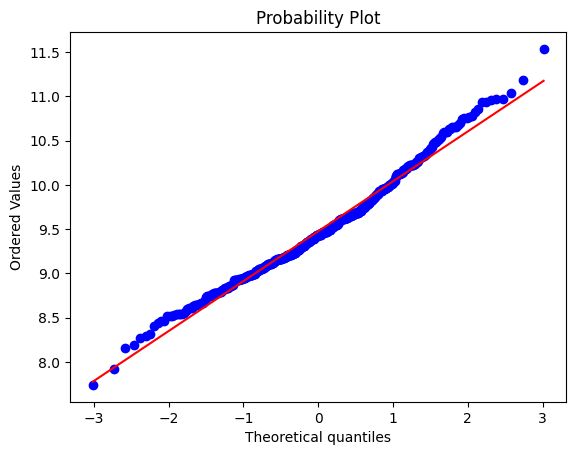

In [61]:
#Log transform sold_price & mileage
df['sold_price'] = np.log(df['sold_price'])
df['mileage'] = np.log1p(df['mileage'])

sns.displot(df['sold_price'])
fig = plt.figure()
res = stats.probplot(df['sold_price'], plot=plt)

In [62]:
# Summarize transformed data
df.describe()

,year,mileage,sold_price,bid_amount,days_since_end,W
count,538.000000,538.000000,538.000000,538.000000,538.000000,538.000000
mean,1976.210037,9.506500,9.476977,15538.013011,1126.293680,0.177161
std,12.253017,2.307071,0.566124,10873.135352,768.672213,0.235096
min,1955.000000,0.693147,7.740664,2300.000000,1.000000,0.000057
25%,1970.000000,9.305741,9.104980,9000.000000,480.250000,0.008762
50%,1972.000000,10.357649,9.433484,12500.000000,998.000000,0.062532
75%,1980.000000,10.915107,9.796035,17962.500000,1706.250000,0.263419
max,2019.000000,12.154785,11.537618,102500.000000,3519.000000,0.997226


In [63]:
# Prepare target and features
y = df["sold_price"]
X = df.drop(["sold_price","bid_amount","end_date", "status", "days_since_end"],axis=1)
X

,year,model,mileage,normalized_color,transmission,W
43,1971,124 Spider,7.208600,Blue,manual,0.020074
44,1975,124 Spider,9.105091,Green,manual,0.034123
45,1971,124 Spider,11.336200,Green,manual,0.000716
46,1970,124 Spider,9.680406,Red,manual,0.029289
47,1979,124 Spider,9.741027,Silver,automatic,0.002635
...,...,...,...,...,...,...
1050,1982,X1/9,10.518700,Red,automatic,0.000057
1051,1980,X1/9,5.993961,Red,manual,0.000259
1052,1979,X1/9,9.852247,Black,manual,0.066095
1053,1980,X1/9,10.463132,Green,manual,0.012175


In [64]:
# Encode categorical features
Lbl_model = LabelEncoder()
Lbl_color = LabelEncoder()
Lbl_trans = LabelEncoder()

#df.make=Lbl.fit_transform(df.make)
X.model=Lbl_model.fit_transform(df.model)
print("Model Mapping:", dict(zip(Lbl_model.classes_, Lbl_model.transform(Lbl_model.classes_))))
X.normalized_color=Lbl_color.fit_transform(df.normalized_color)
print("Color Mapping:", dict(zip(Lbl_color.classes_, Lbl_color.transform(Lbl_color.classes_))))
X.transmission =Lbl_trans.fit_transform(df.transmission)
print("Trans Mapping:", dict(zip(Lbl_trans.classes_, Lbl_trans.transform(Lbl_trans.classes_))))
X

Model Mapping: {'124 Spider': 0, '124 Spider 2000': 1, '124 Sport Coupe': 2, '124 Sport Spider': 3, '500': 4, '500 Abarth': 5, '500 Abarth 5-Speed': 6, '500 Jolly Conversion': 7, '500 L': 8, '500F': 9, '500F Jolly Conversion': 10, '500L': 11, '500R': 12, '600': 13, '600D Multipla': 14, '850 Spider': 15, '850 Sport Spider': 16, 'Dino Coupe': 17, 'Spider 2000': 18, 'X1/9': 19}
Color Mapping: {'Beige': 0, 'Black': 1, 'Blue': 2, 'Brown': 3, 'Burgundy': 4, 'Gold': 5, 'Gray': 6, 'Green': 7, 'Ivory': 8, 'Maroon': 9, 'Orange': 10, 'Pink': 11, 'Red': 12, 'Silver': 13, 'Tan': 14, 'White': 15, 'Yellow': 16}
Trans Mapping: {'automatic': 0, 'manual': 1}


,year,model,mileage,normalized_color,transmission,W
43,1971,0,7.208600,2,1,0.020074
44,1975,0,9.105091,7,1,0.034123
45,1971,0,11.336200,7,1,0.000716
46,1970,0,9.680406,12,1,0.029289
47,1979,0,9.741027,13,0,0.002635
...,...,...,...,...,...,...
1050,1982,19,10.518700,12,0,0.000057
1051,1980,19,5.993961,12,1,0.000259
1052,1979,19,9.852247,1,1,0.066095
1053,1980,19,10.463132,7,1,0.012175


In [65]:
# Fit Model
# Features
# year	model	mileage	normalized_color	transmission

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle = True)

car_model_rf = RandomForestRegressor(n_estimators=150, random_state=33, monotonic_cst = [0,0,-1,0,0,0])
car_model_rf.fit(X,y, sample_weight=X['W'])
print('Random Forest Regressor Train Score is : ' ,  car_model_rf.score(X, y))
#print('Random Forest Regressor Test Score is : ' , car_model_rf.score(X_test, y_test)) 

predicted_rf = pd.DataFrame(car_model_rf.predict(X), index=X.index, columns=['predicted_rf'])
car_model_rf.feature_importances_


Random Forest Regressor Train Score is :  0.5675523390173649


array([0.15973537, 0.20038139, 0.32727012, 0.0828659 , 0.00457951,
       0.22516772])

In [66]:
# Inverse transform features
X_analysis = X.copy()
X_analysis.model = Lbl_model.inverse_transform(X.model)
X_analysis.normalized_color = Lbl_color.inverse_transform(X.normalized_color)
X_analysis.transmission = Lbl_trans.inverse_transform(X.transmission)
X_analysis

,year,model,mileage,normalized_color,transmission,W
43,1971,124 Spider,7.208600,Blue,manual,0.020074
44,1975,124 Spider,9.105091,Green,manual,0.034123
45,1971,124 Spider,11.336200,Green,manual,0.000716
46,1970,124 Spider,9.680406,Red,manual,0.029289
47,1979,124 Spider,9.741027,Silver,automatic,0.002635
...,...,...,...,...,...,...
1050,1982,X1/9,10.518700,Red,automatic,0.000057
1051,1980,X1/9,5.993961,Red,manual,0.000259
1052,1979,X1/9,9.852247,Black,manual,0.066095
1053,1980,X1/9,10.463132,Green,manual,0.012175


In [67]:
# Analyze Results: Add target and predicted values
X_analysis = pd.merge(y, X_analysis, how='inner', left_index=True, right_index=True)
X_analysis = pd.merge(X_analysis, predicted_rf, how='inner', left_index=True, right_index=True)
X_analysis.sold_price = np.exp(X_analysis.sold_price)
X_analysis.predicted_rf = np.exp(X_analysis.predicted_rf)
X_analysis.mileage = np.exp(X_analysis.mileage) - 1
X_analysis

,sold_price,year,model,mileage,normalized_color,transmission,W,predicted_rf
43,15750.0,1971,124 Spider,1350.0,Blue,manual,0.020074,15710.975982
44,8500.0,1975,124 Spider,9000.0,Green,manual,0.034123,13538.075274
45,6700.0,1971,124 Spider,83800.0,Green,manual,0.000716,7412.030602
46,26000.0,1970,124 Spider,16000.0,Red,manual,0.029289,18503.074539
47,6600.0,1979,124 Spider,17000.0,Silver,automatic,0.002635,12235.274311
...,...,...,...,...,...,...,...,...
1050,5100.0,1982,X1/9,37000.0,Red,automatic,0.000057,12073.374434
1051,14750.0,1980,X1/9,400.0,Red,manual,0.000259,15826.426853
1052,25000.0,1979,X1/9,19000.0,Black,manual,0.066095,17519.423472
1053,9300.0,1980,X1/9,35000.0,Green,manual,0.012175,12189.246758


In [68]:
# Define price ranges
def getrange(Price):
    if (Price >= 0 and Price < 50000):
        return '0 - 50000'
    if (Price >= 50000 and Price < 100000):
        return '50000 - 100000'
    if (Price >= 100000 and Price < 150000):
        return '100000 - 150000'
    if (Price >= 150000 and Price < 200000):
        return '150000 - 200000'
    if (Price >= 200000 and Price < 250000):
        return '200000 - 250000'
    if (Price >= 250000 and Price < 300000):
        return '250000 - 300000'
    if (Price >= 300000 and Price < 350000):
        return '300000 - 350000'
    if (Price >= 350000):
        return 'Over 350000'
X_analysis['Price Range'] = X_analysis['sold_price'].apply(lambda x:getrange(x))

X_analysis['Price Range'].value_counts()

Price Range
0 - 50000          528
50000 - 100000       9
100000 - 150000      1
Name: count, dtype: int64

<Axes: xlabel='sold_price', ylabel='predicted_rf'>

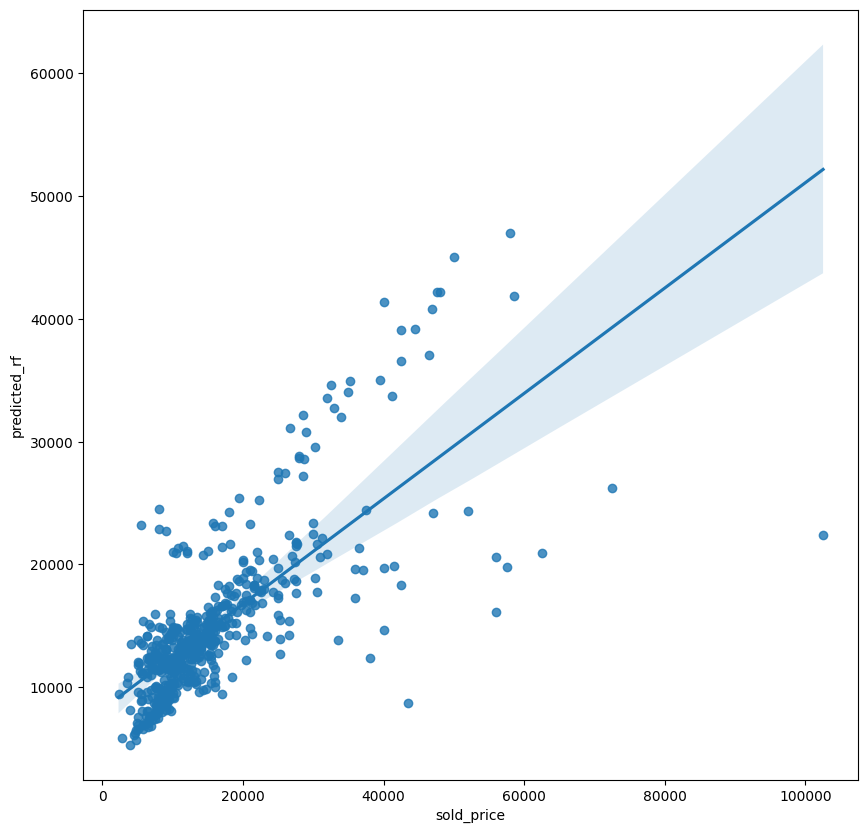

In [69]:
# Plot true vs predicted values scatter

plt.figure(figsize = (10, 10))
sns.regplot(x=X_analysis.sold_price, y=X_analysis.predicted_rf)
#sns.regplot(x=X_analysis.sold_price, y=X_analysis.predicted_xgb)

In [70]:
# Save model
today_date = date.today().strftime('%Y-%m-%d')
path = f"../models/{MAKE}"
if not os.path.exists(path):
    os.makedirs(path)

pickle.dump(car_model_rf, open(f'{path}/model.pkl','wb'))
pickle.dump(Lbl_model, open(f'{path}/labels_model.pkl','wb'))
pickle.dump(Lbl_color, open(f'{path}/labels_color.pkl','wb'))
pickle.dump(Lbl_trans, open(f'{path}/labels_transmission.pkl','wb'))

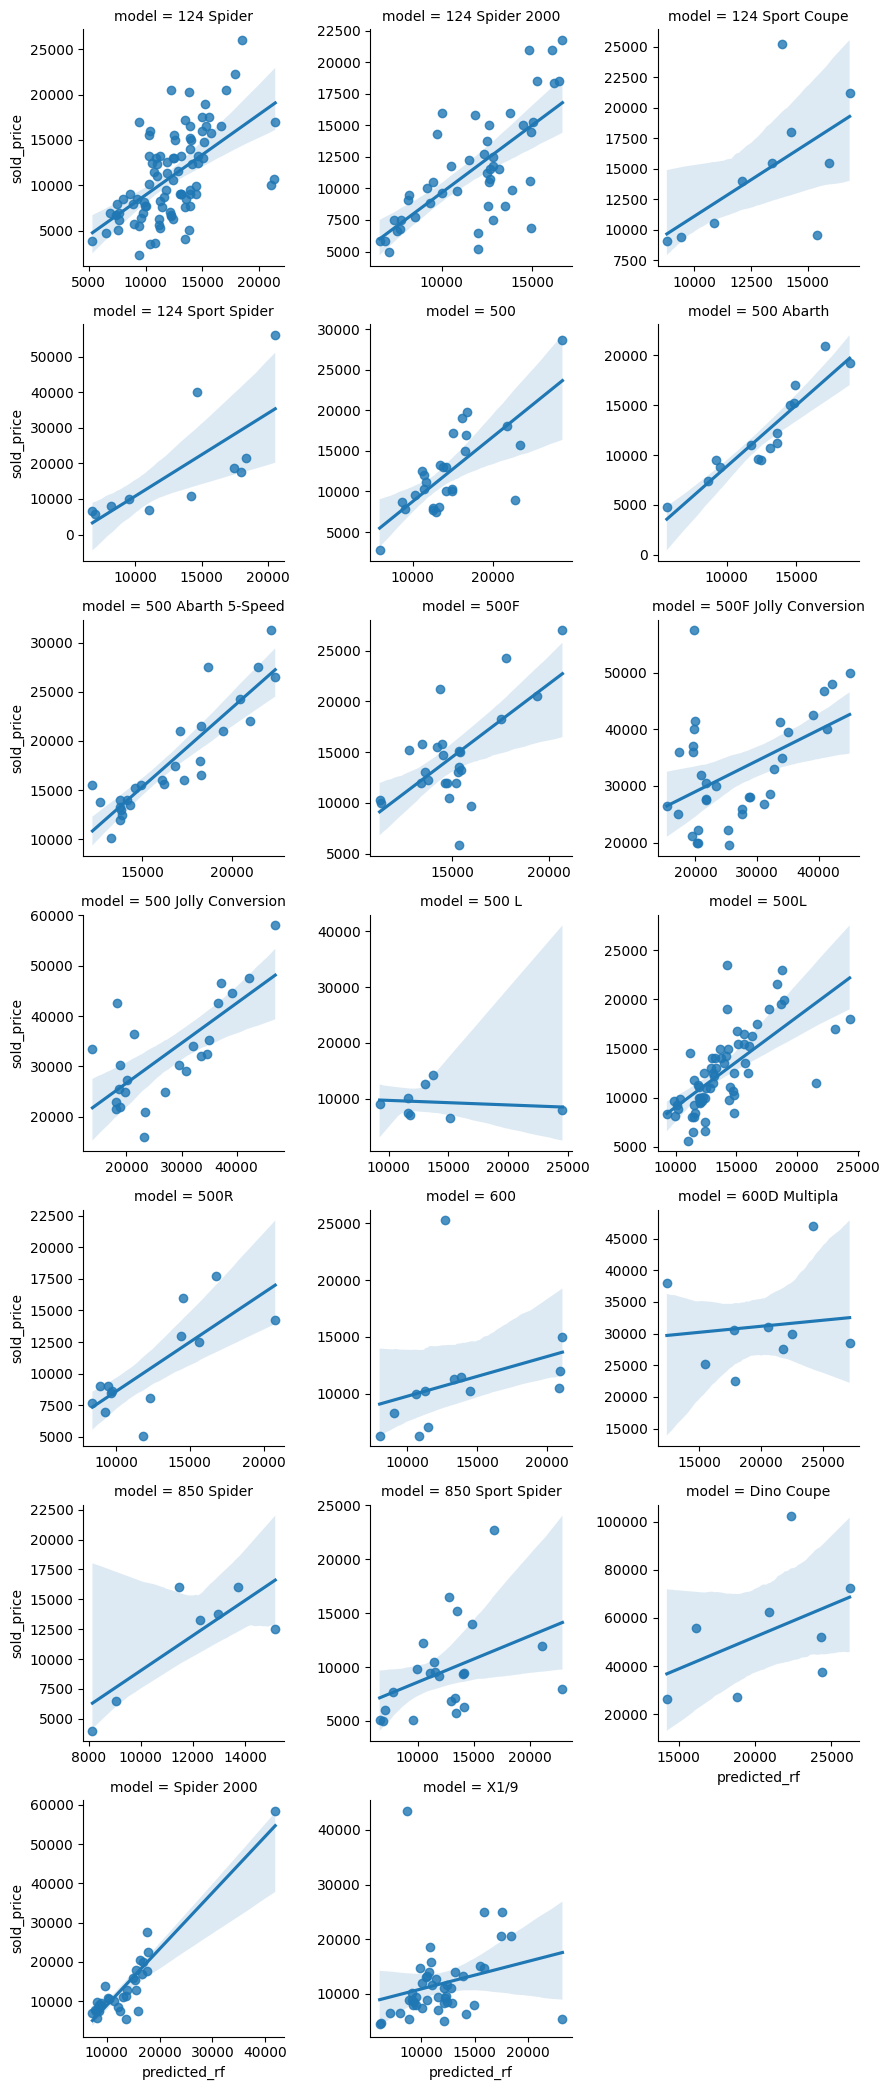

In [71]:
# Predicted vs Sold Price Scatter by model
g = sns.FacetGrid(X_analysis, col="model", col_wrap=3, sharex=False, sharey=False)

# Map scatter plots to the grid
g.map(sns.regplot, "predicted_rf", "sold_price")

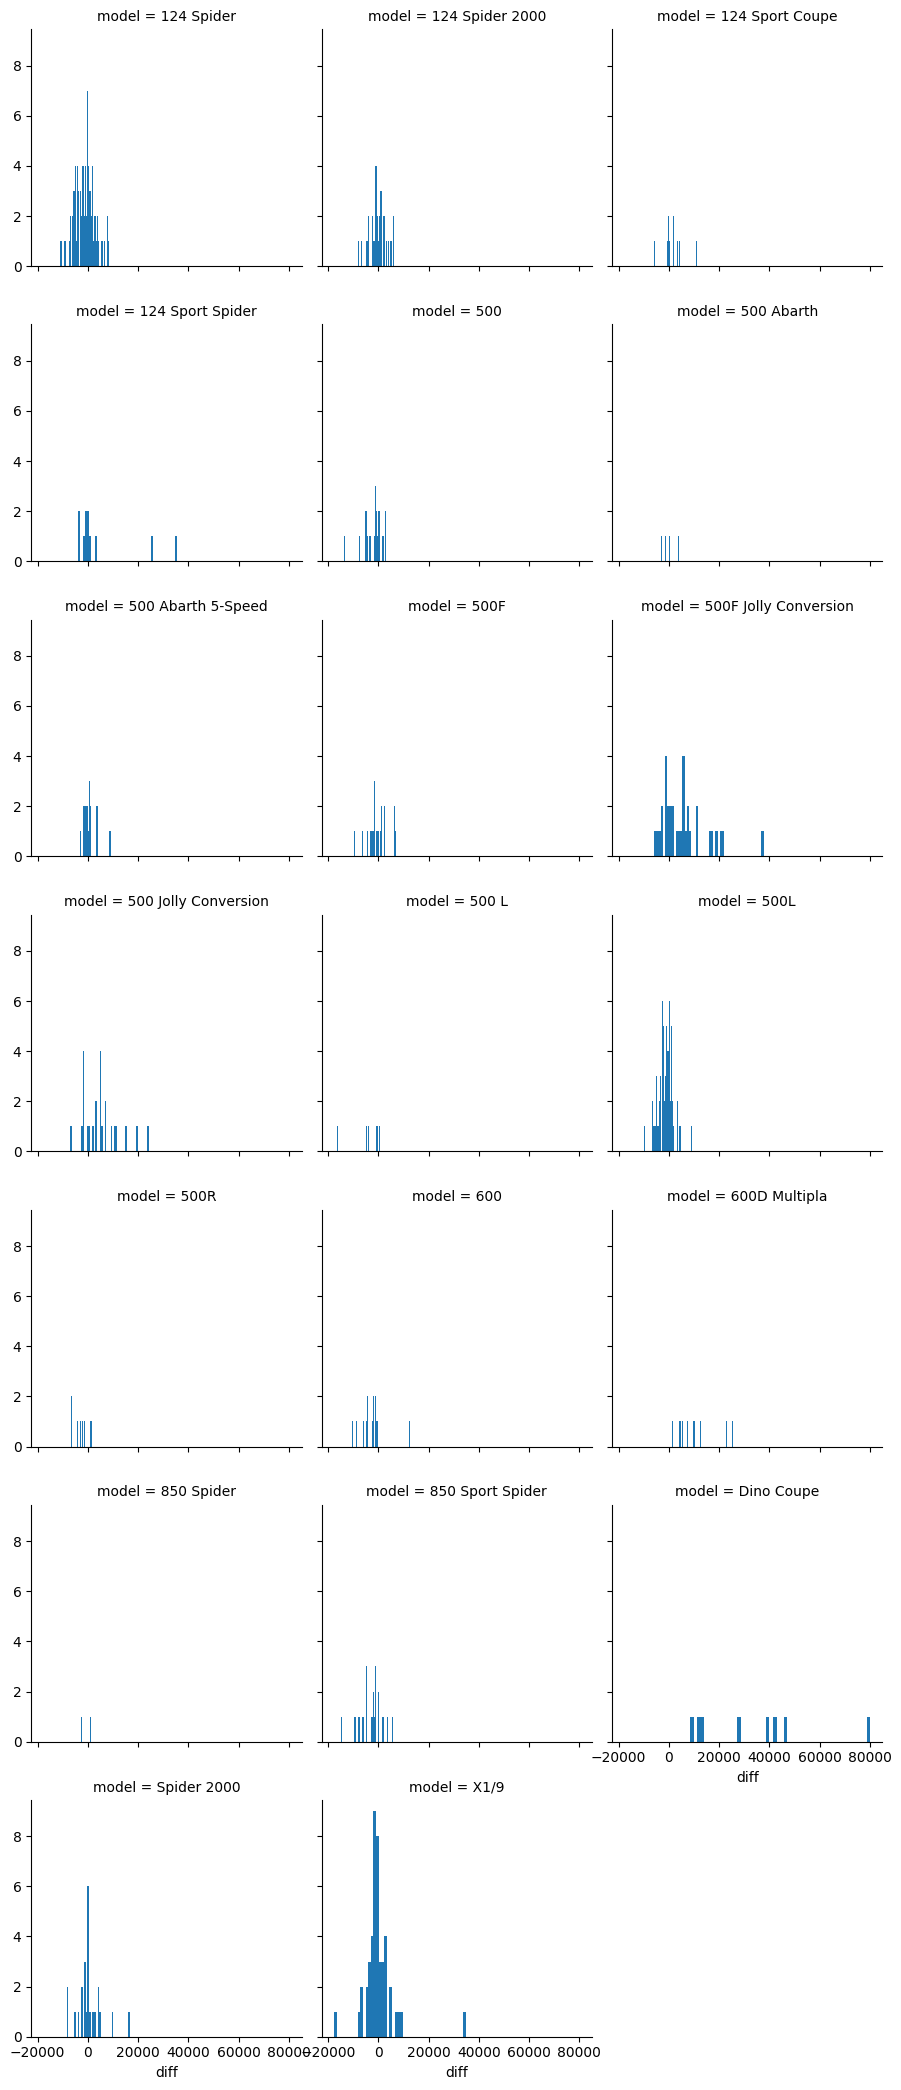

In [72]:
# Analyze Residuals by model
X_analysis['diff'] = X_analysis.sold_price - X_analysis.predicted_rf
g = sns.FacetGrid(X_analysis, col="model", col_wrap=3)

# Map scatter plots to the grid
g.map(plt.hist, "diff", bins = 50)


In [73]:
# Prediction function

def predict(year, model, mileage, color, transmission, carmodel, W):
    input_data = pd.DataFrame([[year, model, mileage, color, transmission, W]], 
                              columns=["year", "model", "mileage", "normalized_color", "transmission", "W"])
    input_data.model=Lbl_model.transform(input_data.model)
    input_data.normalized_color=Lbl_color.transform(input_data.normalized_color)
    input_data.transmission=Lbl_trans.transform(input_data.transmission)
    input_data.mileage = np.log1p(input_data.mileage)
    price_scaled = carmodel.predict(input_data)

    price = np.exp(price_scaled)
    
    return price[0].round(0)

In [74]:
# Run a prediction for a car over a range of mileage
mileage_range = np.linspace(0, 50000, 100)

predictions = []
for mileage in mileage_range:
    prediction = predict(
        year = 1992,
        model = "512 TR",
        mileage = mileage,
        color = "Black",
        transmission = "manual",
        carmodel = car_model_rf,
        W = 1
    )
    predictions.append(prediction)

predictions = pd.DataFrame(predictions, columns=["predicted"])
mileage_range = pd.DataFrame(mileage_range, columns=["mileage"])
predictions = pd.merge(predictions, mileage_range, how='inner', left_index=True, right_index=True)
plt.scatter(predictions["mileage"], predictions["predicted"])

ValueError: y contains previously unseen labels: '512 TR'